# CS4447 Final Project - Predicting Real Disasters from Tweets
## Hafez Gharbiah, Tyler Christeson
## data: https://www.kaggle.com/vbmokin/nlp-with-disaster-tweets-cleaning-data

## Rubric + Guidelines
1. Proper tagging of Github repository for final report as per deadlines (0.5 = 0.25 + 0.25 points)
1. Dataset and motivation slide (1 points)
    - How/why the dataset was collected and a description of the metadata of your dataset.
1. Actual task definition/research question (2 points)
    - What real-world problem are you trying to solve? What are the input and output of your analysis?
1. Literature review (2 points)
    - What other work has been done in this area, and how is your work novel compared to others?
1. Quality of cleaning (6 points, 2 points each) 
    - Data cleaning and type conversion activity. Please share anything unusual you faced during this activity.
    - What did you do about missing values and why? Handling missing values properly is very important.
    - New feature/attribute creation and data summary statistics and interpretation.
1. Visualization (8 points, 2 points each)
    - Data visualization activity (box plot, bar plot, violin plot, and pairplot to see relationships and distribution, etc.).
    - Describe anything you find in the data after each visualization.
    - What data visualization helped you understand about data distribution.
    - What you did about possible outlier as per data distribution visualization. (Did you confirm with your client whether it is actually an outlier or put a disclosure statement in your notebook if you decided to remove it?)

- The problem we're trying to solve is predicting whether a tweet is about a real disaster or not, which can be used to determine if emergency services need to be sent.

- We have a collection of 10,000 tweets. The attributes of the dataset are a unique identifier for each tweet, text of the tweet, where the tweet was sent from, keywords that could be used to identify disasters, and whether or not it is about a real disaster (only on some of them).

- Examples of records:
    - "Heard about # earthquake is different cities, stay safe everyone ." 
    - "Please like and share our new page for our Indoor Trampoline Park Aftershock opening this fall !" 
    - " nowplaying Alfons - Ablaze 2015 on Puls Radio pulsradio" 
    - "Coincidence Or # Curse ? Still # Unresolved Secrets From Past # accident"

- This is a noisy data set because the tweets are not all about disasters, and certain disaster keywords are used in contexts that are not disasters . For example, while "ablaze" is used in several real disaster tweets about ongoing fires, in the above example it is used as a song title. The same is true for many keywords, like "accident" and "aftershock" above.

- Feature engineering can be used in this dataset to:
    - extract years to see if we're tweeting about events that aren't current
    - extract news network name to determine if the accident is being reported on or not
    - topic modeling to extract relevant topics as features

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import pandas as pd
import numpy as np
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('averaged_perceptron_tagger')
import string
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
import sklearn
# from sklearn.naive_bayes import GaussianNB
# from sklearn.metrics import confusion_matrix
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier

/mnt/c/users/chris/desktop/atomprojects/cs4447/dst1_env/lib/python3.8/site-packages/sklearn/feature_extraction/image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):
/mnt/c/users/chris/desktop/atomprojects/cs4447/dst1_env/lib/python3.8/site-packages/sklearn/linear_model/least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float

In [3]:
traindf = pd.read_csv('train_data_cleaning.csv',index_col=0)
testdf = pd.read_csv('test_data_cleaning.csv',index_col=0)
# traindf.keyword[traindf.target==0].value_counts()
traindf

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this # earthquake...,1
4,NaN,NaN,Forest fire near La Ronge Sask . Canada,1
5,NaN,NaN,All residents asked to ' shelter in place ' ...,1
6,NaN,NaN,"13,000 people receive # wildfires evacuation ...",1
7,NaN,NaN,Just got sent this photo from Ruby # Alaska a...,1
...,...,...,...,...
10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
10870,NaN,NaN,@ Aria Ahrary @ TheTawniest The out of contr...,1
10871,NaN,NaN,M1 . 94 [ 01 : 04 UTC ] ? 5km S of Volcano H...,1


In [4]:
# Quality of cleaning (6 points, 2 points each)
### Data cleaning and type conversion activity. Please share anything unusual you faced during this activity.
### What did you do about missing values and why? Handling missing values properly is very important.
### New feature/attribute creation and data summary statistics and interpretation. 
train_text = traindf.text
stopwords = nltk.corpus.stopwords.words('english')
stopwords = set(stopwords + list(string.punctuation))
train_text = [nltk.word_tokenize(i) for i in train_text]
train_text = [[w.lower() for w in train_text[i] if w not in stopwords] for i in range(len(train_text))]

wnetl = WordNetLemmatizer()

def nltk_tag_pos(tag):   
    #adapted from https://stackoverflow.com/questions/15586721/wordnet-lemmatization-and-pos-tagging-in-python
    if tag[0]=='J':
        return wordnet.ADJ
    elif tag[0]=='V':
        return wordnet.VERB
    elif tag[0]=='N':
        return wordnet.NOUN
    elif tag[0]=='R':
        return wordnet.ADV
    else:          
        return wordnet.NOUN #noun is default lemmatize POS
    
train_text_POS = [nltk.pos_tag(i) for i in train_text]    
train_text = [[wnetl.lemmatize(i[0],nltk_tag_pos(i[1])) for i in j] for j in train_text_POS]
traindf['tweet_length'] = [len(w) for w in train_text]
train_text = [' '.join(train_text[i]) for i in range(len(train_text))]

traindf.text = train_text

Text(0, 0.5, 'Count')

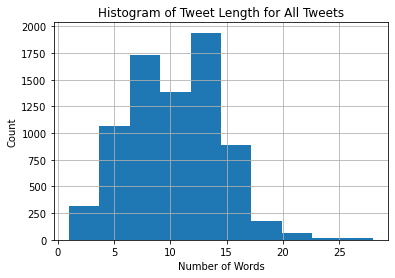

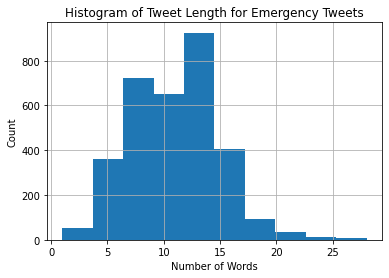

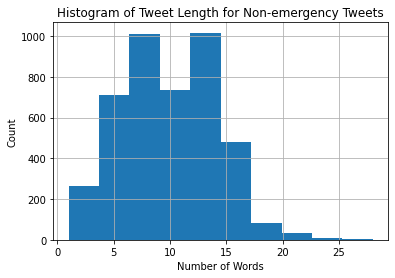

In [5]:
# g = sns.catplot(x="target",y="tweet_length",data=traindf)
%matplotlib inline
fig, ax = plt.subplots()
ax= traindf.tweet_length.hist()
ax.set_title('Histogram of Tweet Length for All Tweets')
ax.set_xlabel('Number of Words')
ax.set_ylabel('Count')

fig, ax = plt.subplots()
ax = traindf.tweet_length[traindf.target==1].hist()
ax.set_title('Histogram of Tweet Length for Emergency Tweets')
ax.set_xlabel('Number of Words')
ax.set_ylabel('Count')

fig, ax = plt.subplots()
ax = traindf.tweet_length[traindf.target==0].hist()
ax.set_title('Histogram of Tweet Length for Non-emergency Tweets')
ax.set_xlabel('Number of Words')
ax.set_ylabel('Count')

In [6]:
#bag of words model
cv = CountVectorizer()
x= cv.fit_transform(train_text).toarray()
y = traindf.target.values

#70:30 train-test split
xtrain, xtest, ytrain, ytest = sklearn.model_selection.train_test_split(x,y,test_size=0.3,random_state=1234)

import sklearn.naive_bayes
classifier = sklearn.naive_bayes.GaussianNB()
classifier.fit(xtrain,ytrain)

ypred = classifier.predict(xtest)
ypred

confusionMatrix = sklearn.metrics.confusion_matrix(ytest,ypred)
print(confusionMatrix)
tn, fp, fn, tp = confusionMatrix.ravel()
accuracy = (tp+tn)/(sum(sum(confusionMatrix)))
precision = tp / (tp+fp)
modeldf = pd.DataFrame()
models = ['Gaussian Naive Bayes']
precisions = [precision]
print(f'Model precision is: {precision}')

[[609 679]
 [207 789]]
Model precision is: 0.5374659400544959


In [7]:
xtrain, xtest, ytrain, ytest = sklearn.model_selection.train_test_split(traindf.text, traindf.target, test_size=0.3, random_state=1234)

In [8]:
from sklearn.naive_bayes import MultinomialNB

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(xtrain, ytrain)
            
ypred = nb.predict(xtest)

confusionMatrix = sklearn.metrics.confusion_matrix(ytest,ypred)
print(confusionMatrix)
tn, fp, fn, tp = confusionMatrix.ravel()
accuracy = (tp+tn)/(sum(sum(confusionMatrix)))
precision = tp / (tp+fp)
models.append('Multinomial Naive Bayes')
precisions.append(precision)
print(f'Model precision is: {precision}')

[[1162  126]
 [ 319  677]]
Model precision is: 0.8430884184308842


In [9]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(xtrain, ytrain)

ypred = sgd.predict(xtest)

confusionMatrix = sklearn.metrics.confusion_matrix(ytest,ypred)
print(confusionMatrix)
tn, fp, fn, tp = confusionMatrix.ravel()
accuracy = (tp+tn)/(sum(sum(confusionMatrix)))
precision = tp / (tp+fp)
models.append('SGF Classifier')
precisions.append(precision)
print(f'Model precision is: {precision}')

[[1238   50]
 [ 458  538]]
Model precision is: 0.9149659863945578


/mnt/c/users/chris/desktop/atomprojects/cs4447/dst1_env/lib/python3.8/site-packages/sklearn/linear_model/stochastic_gradient.py:176: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  warnings.warn(
/mnt/c/users/chris/desktop/atomprojects/cs4447/dst1_env/lib/python3.8/site-packages/sklearn/linear_model/base.py:283: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidan

In [10]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(xtrain, ytrain)

ypred = logreg.predict(xtest)

confusionMatrix = sklearn.metrics.confusion_matrix(ytest,ypred)
print(confusionMatrix)
tn, fp, fn, tp = confusionMatrix.ravel()
accuracy = (tp+tn)/(sum(sum(confusionMatrix)))
precision = tp / (tp+fp)
models.append('Logistic Regression')
precisions.append(precision)
print(f'Model precision is: {precision}')

/mnt/c/users/chris/desktop/atomprojects/cs4447/dst1_env/lib/python3.8/site-packages/sklearn/linear_model/logistic.py:431: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  warnings.warn("Default solver will be changed to 'lbfgs' in 0.22. "


[[1014  274]
 [ 276  720]]
Model precision is: 0.7243460764587525


/mnt/c/users/chris/desktop/atomprojects/cs4447/dst1_env/lib/python3.8/site-packages/sklearn/linear_model/base.py:283: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = (scores > 0).astype(np.int)


# Visualizations to Include:
1. bar plot comparing models' precisions, and using that we can narrow it down and describe our chosen model more. (looks like SGDClassifier, btw)
1. Top 10 words before stop words+lemmatization, and Top 10 words after to show the effect of cleaning
1. histograms of tweet lengths for target = 1, target =0, or all tweets together
1. any other ideas welcome

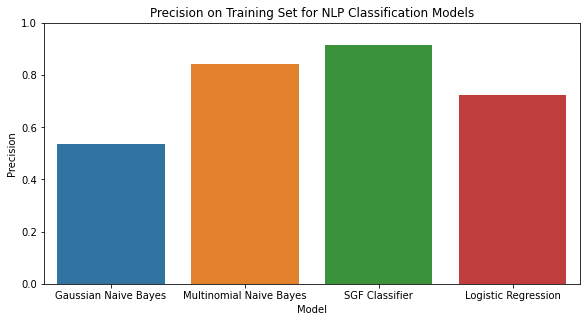

In [30]:
modeldf['model']=models
modeldf['precision']=precisions
modeldf
plt.figure(figsize=(9.6,4.8))
g= sns.barplot(x='model', y='precision',data=modeldf)
# g.set_xticklabels(rotation=30,labels=modeldf.model)
g.set(xlabel='Model', ylabel='Precision')
g.set_title('Precision on Training Set for NLP Classification Models')
g.set_ylim(0,1)
# for index, row in modeldf.iterrows():
#     g.text(row.model,row.precision, round(row.precision,2), color='black', ha="center")
plt.show()